# **PENDAHULUAN**
Pembuka Notebook "train_yolo8.ipynb" ini disusun secara khusus untuk memenuhi tugas besar mata kuliah Visi Komputer yang diampu oleh Bapak Henry Tantyoko Henri Tantyoko, S.Kom., M.Kom


Disusun Oleh:

Nama: Wahidatuzzahro Febria Fithrurrahmah

NIM: 24060122120008


Di dalam notebook ini, saya melakukan proses training model untuk mendeteksi lubang jalan (pothole) dengan tahapan sebagai berikut:

1. Load & Split Data: Dataset diunduh otomatis via Roboflow API. Sistem membagi data menjadi 1.375 gambar (Train) untuk pembelajaran model dan 281 gambar (Validasi) untuk pengujian akurasi.
2. Konfigurasi Model: Menggunakan arsitektur YOLOv8s (Small) dengan input size 640px dan dijalankan sebanyak 100 epoch.

3. Augmentasi: Menerapkan teknik Albumentations (Blur, Gray, CLAHE) agar model tetap akurat meski kondisi cahaya/cuaca pada gambar berubah-ubah.

Setelah proses training selesai, dihasilkan file best.pt. File ini adalah bobot (weights) terbaik yang memiliki tingkat presisi tertinggi. Kegunaannya adalah:

- Inference Engine: Berperan sebagai model prediktif untuk melakukan deteksi objek secara otomatis pada data visual baru (foto/video) dengan tingkat kepercayaan (confidence score) yang optimal.

- Deployment Ready: Merupakan model final yang siap diintegrasikan ke dalam infrastruktur perangkat lunak, seperti sistem monitoring jalan berbasis mobile atau web-based GIS, guna mendukung otomatisasi pemeliharaan jalan raya.

# **Environment & Setup**

Dalam pengerjaan ini, saya memanfaatkan akselerasi GPU Tesla T4 untuk mempercepat proses komputasi. Saya mengonfigurasi library utama menggunakan Ultralytics YOLOv8.0.196 dan PyTorch sebagai framework dasar pengembangan model.

In [1]:
import torch
from functools import partial

# Memaksa torch.load untuk selalu mengizinkan loading model (weights_only=False)
torch.load = partial(torch.load, weights_only=False)


In [2]:
!nvidia-smi

Mon Dec 22 14:06:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.5/112.6 GB disk)


# **Dataset Acquisition**
Untuk dataset, saya telah membuat dataset yang berasal dari gambar raw (entar) dari berbagai sumber seperti kaggle, video, gambar, dan lain-lain, dataset tersebut sata berikan annotasi menggunakan Roboflow AI dengan proyek "pothole-detection-without-speedbreaker", di mana data tersebut saya bagi menjadi dua bagian, yaitu 1.375 gambar untuk fase training dan 281 gambar untuk fase validation guna menguji akurasi model secara objektif.

In [5]:
import os
HOME = os.getcwd()

!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="IscNqAnd17U0jATh2ADF")
project = rf.workspace("febgabut").project("pothole-detection-without-speedbreaker")
version = project.version(1)
dataset = version.download("yolov8")

/content/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.7 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole-Detection(without-speedbreaker)-1 in yolov8:: 100%|██████████| 3672/3672 [00:00<00:00, 7481.76it/s]


# **Model Configuration**
Pada bagian ini, saya memilih menggunakan yolov8s.pt (YOLOv8 Small) yang memiliki 225 layer dengan 11,1 juta parameter. Model ini saya latih selama 100 epoch dengan ukuran gambar 640x640 piksel. Untuk memastikan model tetap tangguh dalam berbagai kondisi cuaca dan pencahayaan di lapangan, saya menerapkan teknik augmentasi dari Albumentations seperti Blur, GrayScale, dan CLAHE. Selama proses training menggunakan optimizer AdamW, terlihat peningkatan nilai mAP50 yang sangat stabil hingga mencapai angka di atas 0.8 (80%+), yang menandakan bahwa model memiliki kemampuan deteksi yang sangat presisi.

In [7]:
from ultralytics import YOLO

# 1. Load model dasar
# Karena ini deteksi pothole, pastikan menggunakan yolov8s.pt atau yolov8s-seg.pt
model = YOLO('yolov8s.pt')

# 2. Jalankan Training
model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=100,
    imgsz=640,
    plots=True
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 59.2MB/s]
New https://pypi.org/project/ultralytics/8.3.241 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/Pothole-Detection(without-speedbreaker)-1/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d2162aa2690>
fitness: np.float64(0.5779097061310424)
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.54583,     0.54583])
names: {0: '4', 1: 'pothole'}
plot: True
results_dict: {'metrics/precision(B)': np.float64(0.8766428937607627), 'metrics/recall(B)': np.float64(0.7933836747052395), 'metrics/mAP50(B)': np.float64(0.8666119664958469), 'metrics/mAP50-95(B)': np.float64(0.5458316772016197), 'fitness': np.float64(0.5779097061310424)}
save_dir: PosixPath('runs/detect/train')
speed: {'preprocess': 0.25307580669579555, 'inference': 4.16457695468889, 'loss': 0.0006685901791175489, 'postprocess': 2.76619768651779}

# **Performance Tracking**

Melalui visualisasi data pada notebook, saya mengamati adanya peningkatan akurasi yang signifikan sejak awal epoch, di mana nilai mAP50 berhasil menyentuh angka di atas 0.8 (80%) pada pertengahan proses. Hal ini menunjukkan bahwa model yang saya kembangkan sudah memiliki kemampuan generalisasi yang baik dan tingkat presisi yang tinggi dalam membedakan antara objek lubang dengan tekstur aspal lainnya.

Selain itu, saya juga memantau Loss Function (terdiri dari box loss, cls loss, dan dfl loss) yang terus menurun secara konsisten. Penurunan grafik loss ini menjadi indikator bahwa model saya semakin minim dalam melakukan kesalahan lokalisasi posisi lubang maupun kesalahan klasifikasi objek, sehingga hasil akhir yang disimpan dalam file best.pt benar-benar merupakan versi model yang paling optimal untuk diimplementasikan.

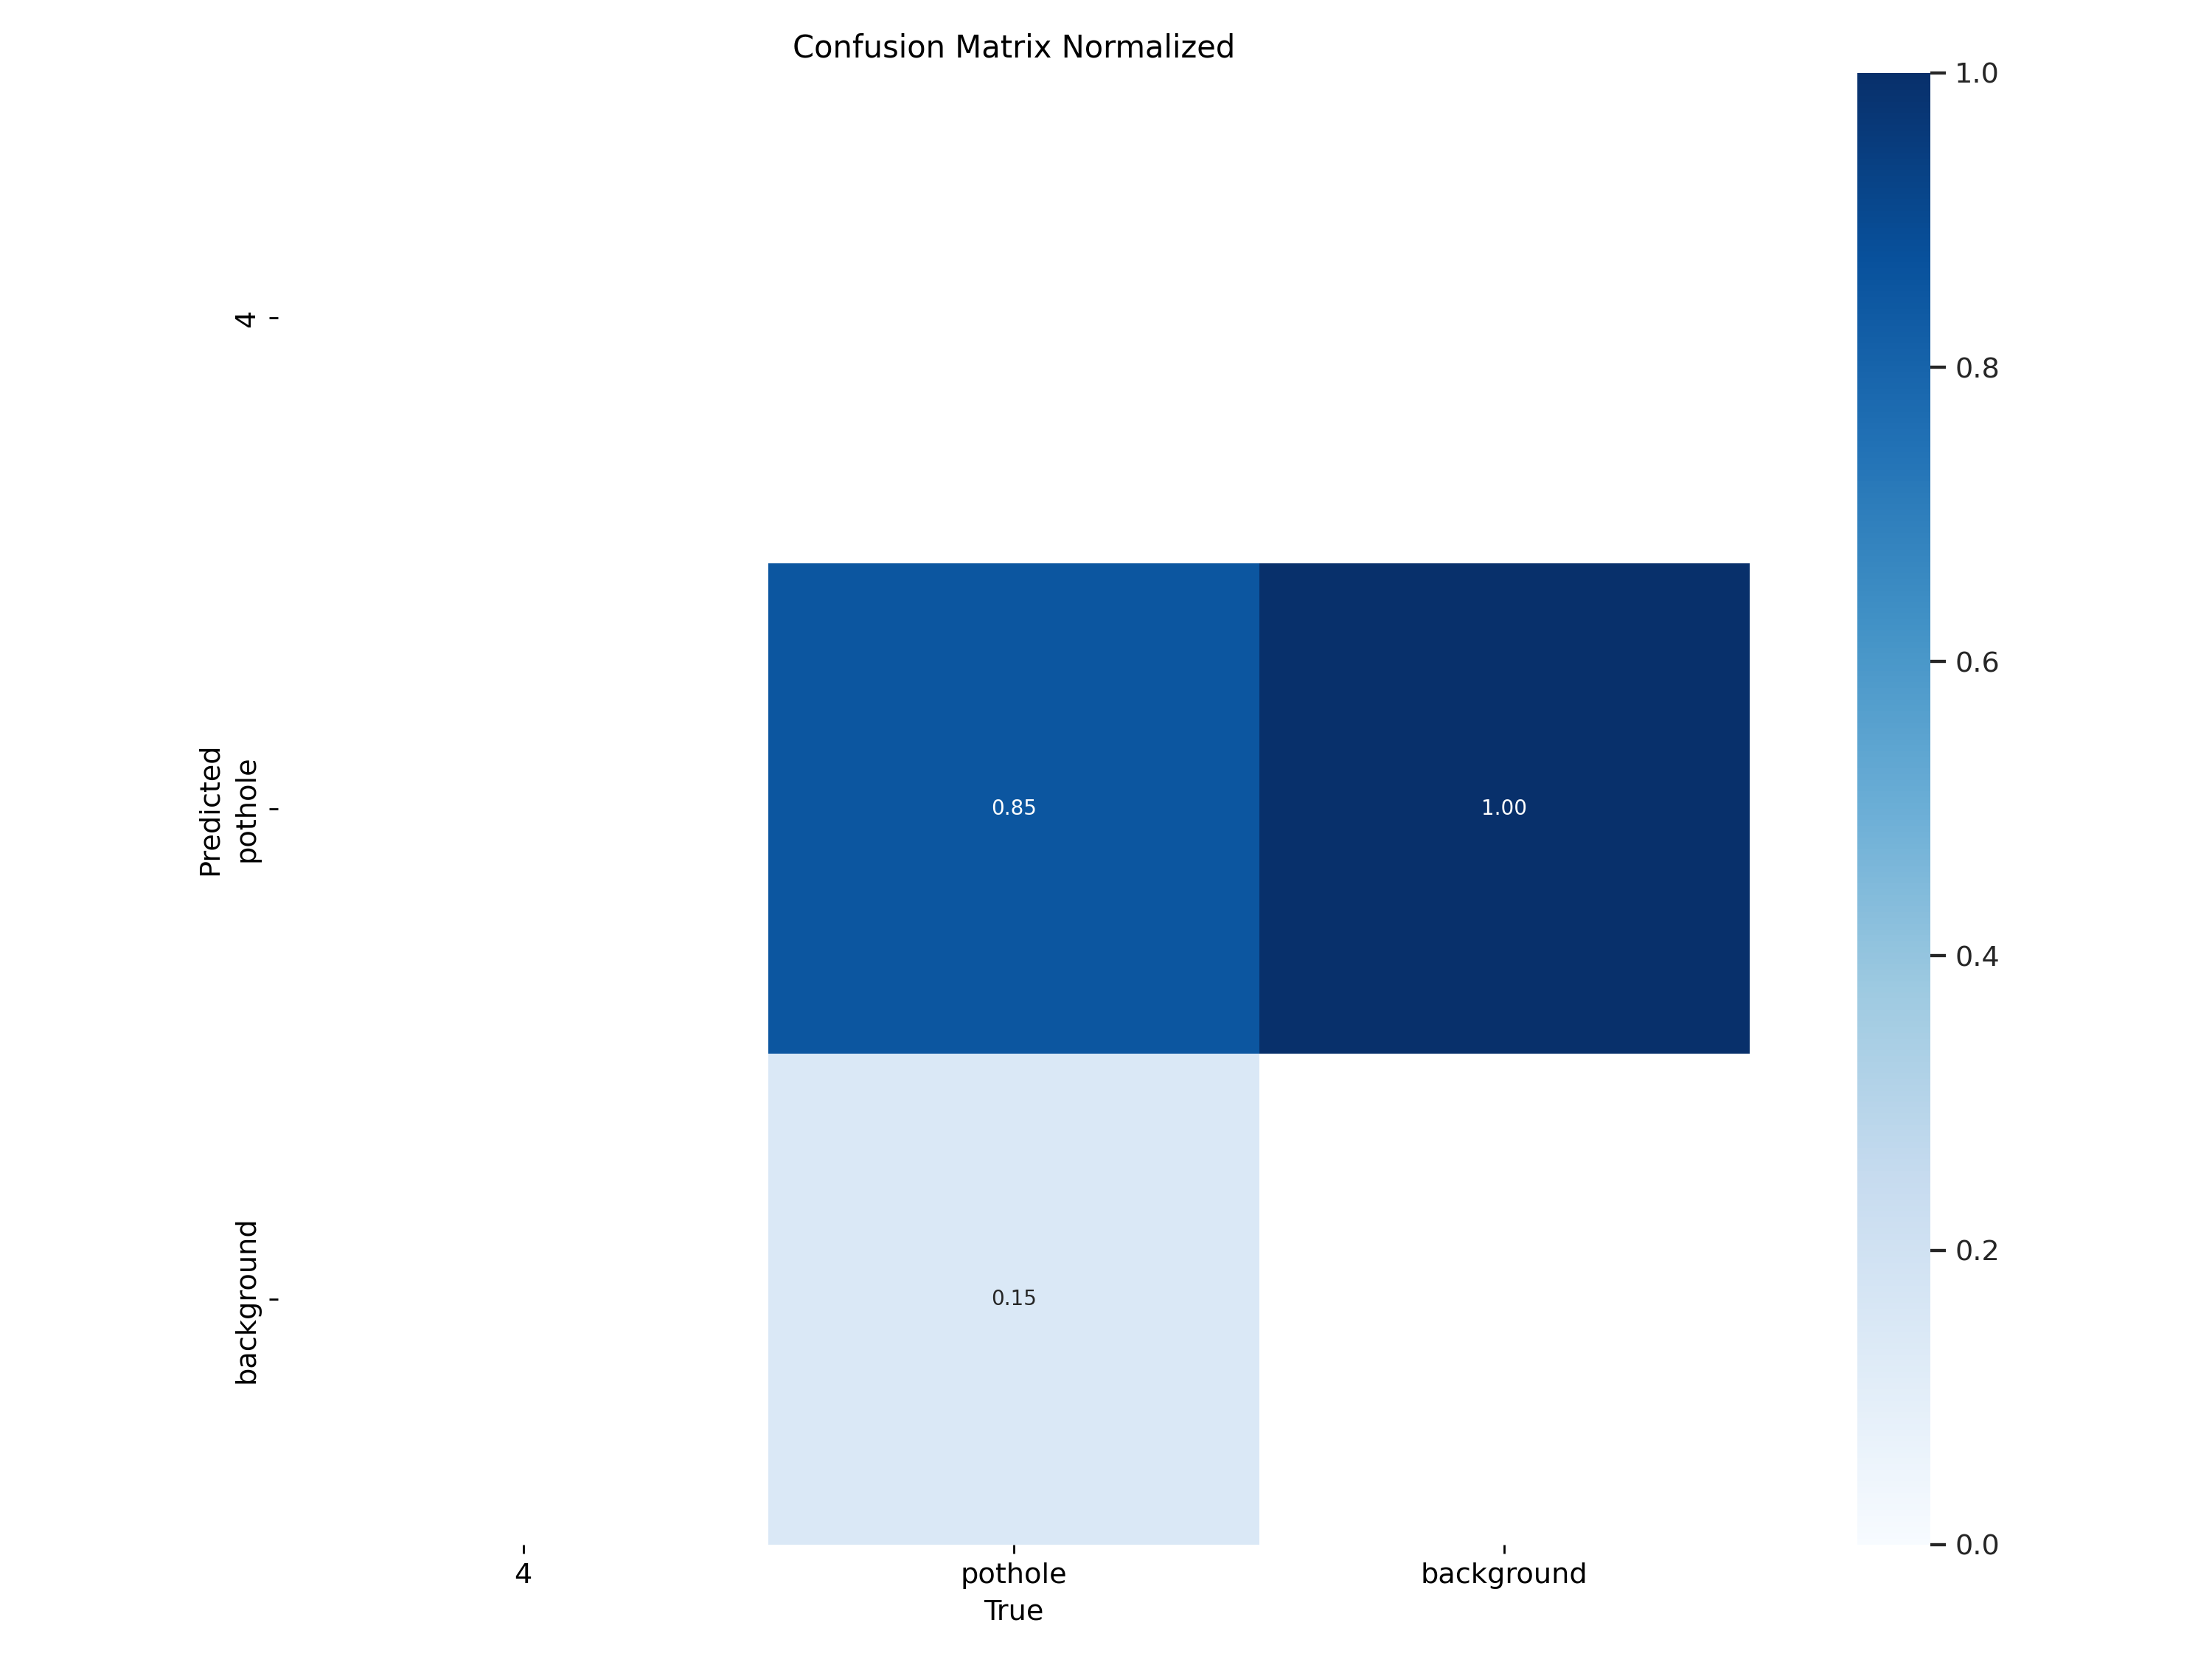

In [16]:
from IPython.display import Image

Image(filename=f'/content/datasets/runs/detect/train/confusion_matrix_normalized.png', width=1000)

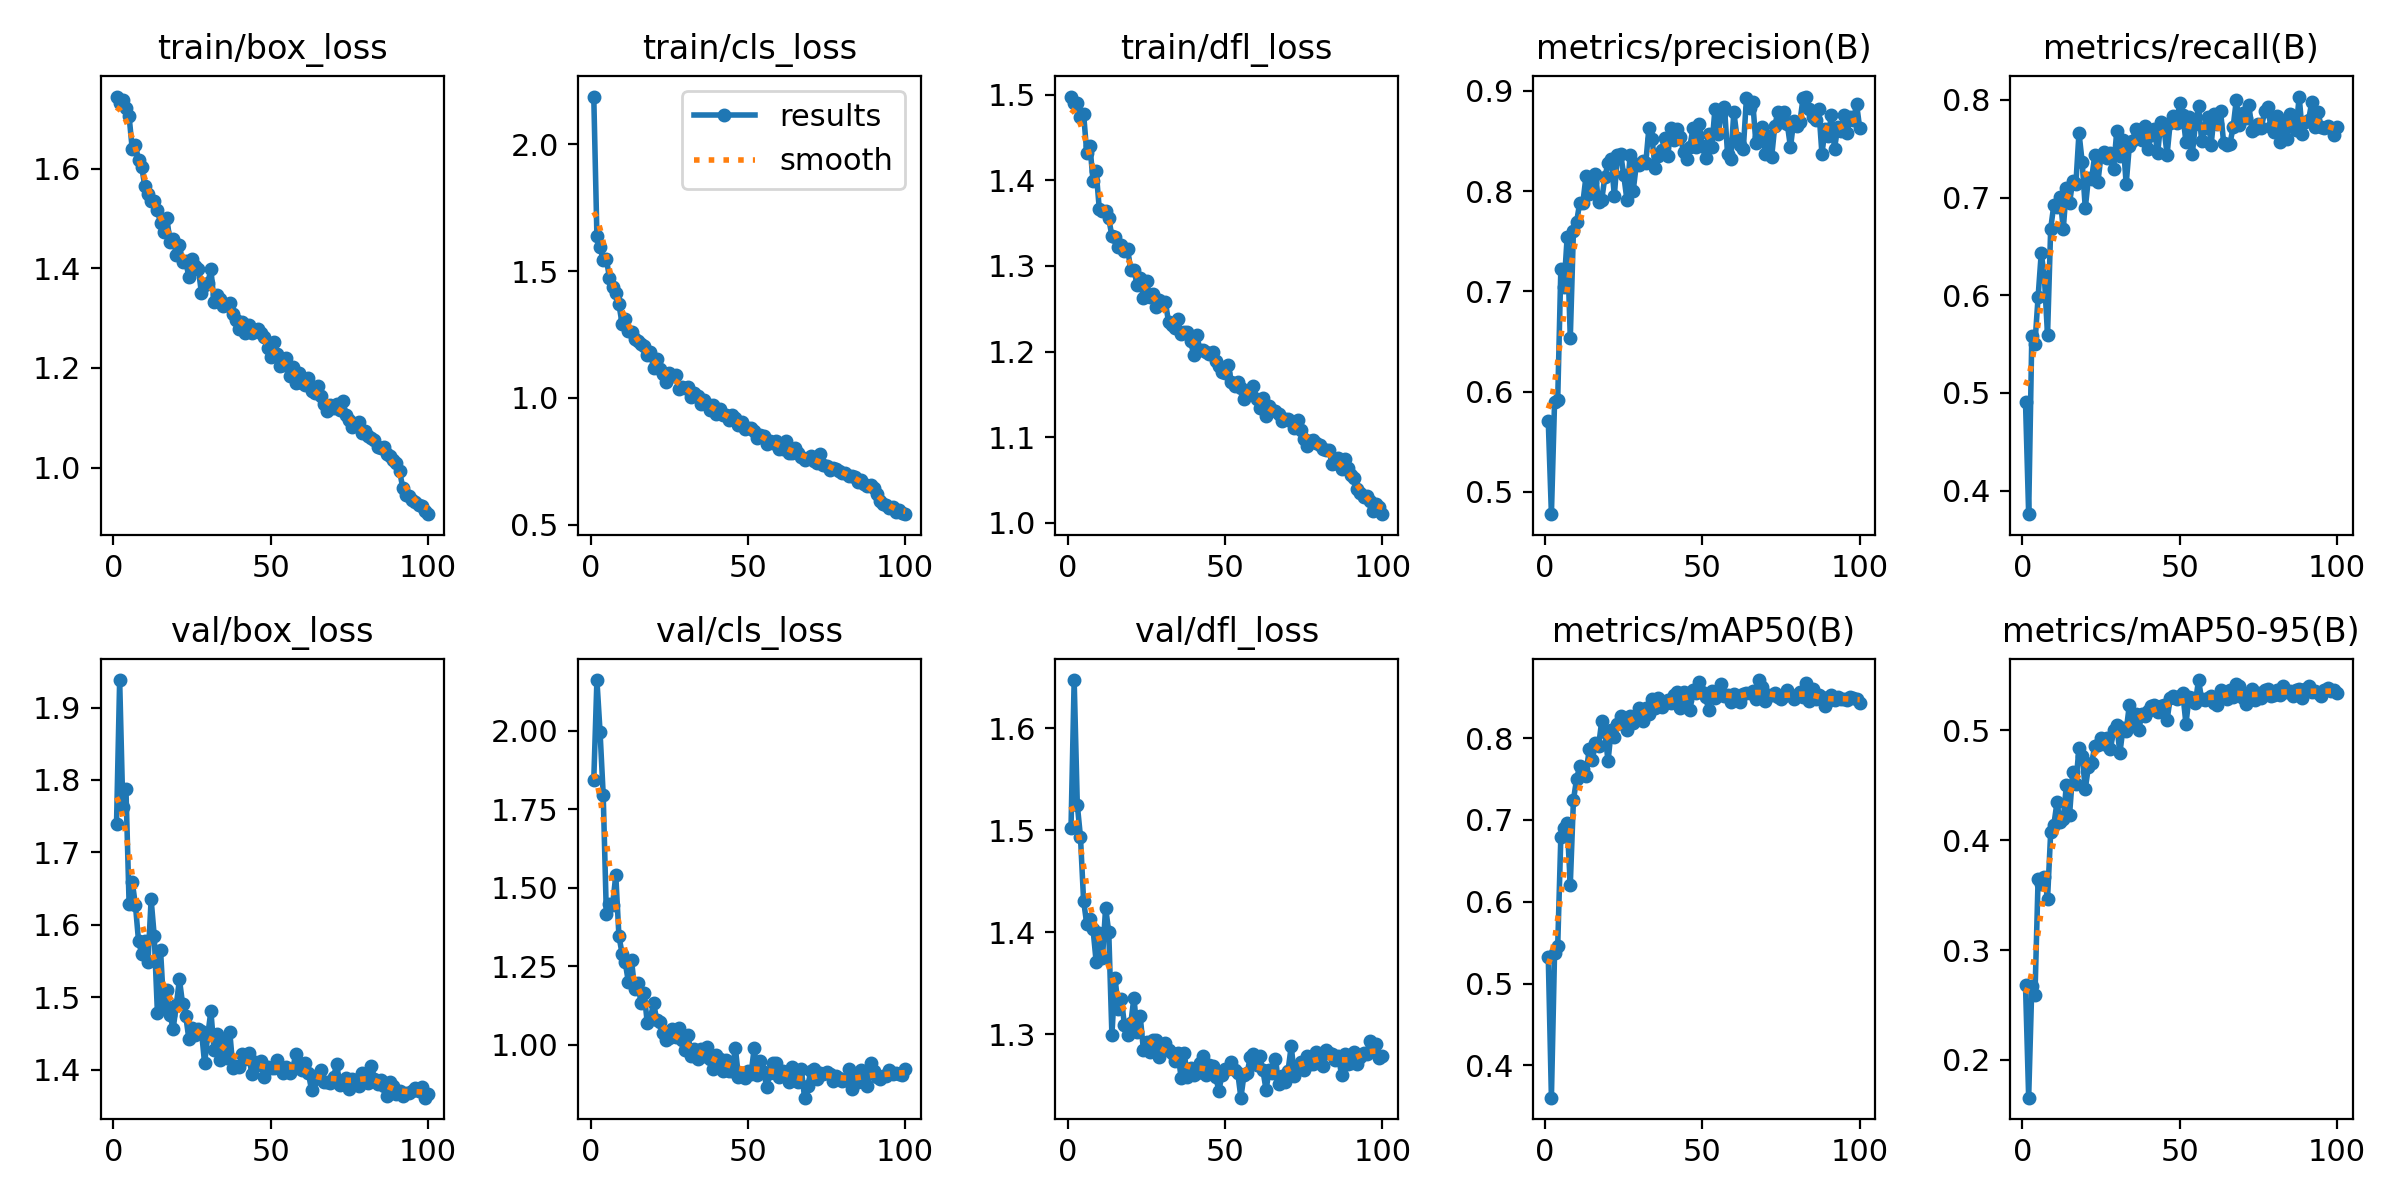

In [15]:
from IPython.display import display, Image

# Menampilkan grafik metrik utama
display(Image(filename=f'/content/datasets/runs/detect/train/results.png', width=800))

In [21]:
from ultralytics import YOLO

# Load model terbaik hasil training tadi
model = YOLO('/content/datasets/runs/detect/train/weights/best.pt')

# Jalankan validasi pada dataset
# Ini akan otomatis menghitung mAP50, mAP50-95, dll.
metrics = model.val()

print(f"Hasil mAP 50: {metrics.box.map50}")
print(f"Hasil mAP 50-95: {metrics.box.map}")

Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/Pothole-Detection(without-speedbreaker)-1/valid/labels.cache... 281 images, 27 backgrounds, 0 corrupt: 100%|██████████| 281/281 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.37it/s]
                   all        281       1048      0.876      0.794      0.867      0.546
               pothole        281       1048      0.876      0.794      0.867      0.546
Speed: 0.5ms preprocess, 7.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val


Hasil mAP 50: 0.8666244787355928
Hasil mAP 50-95: 0.5456829175829966


In [22]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

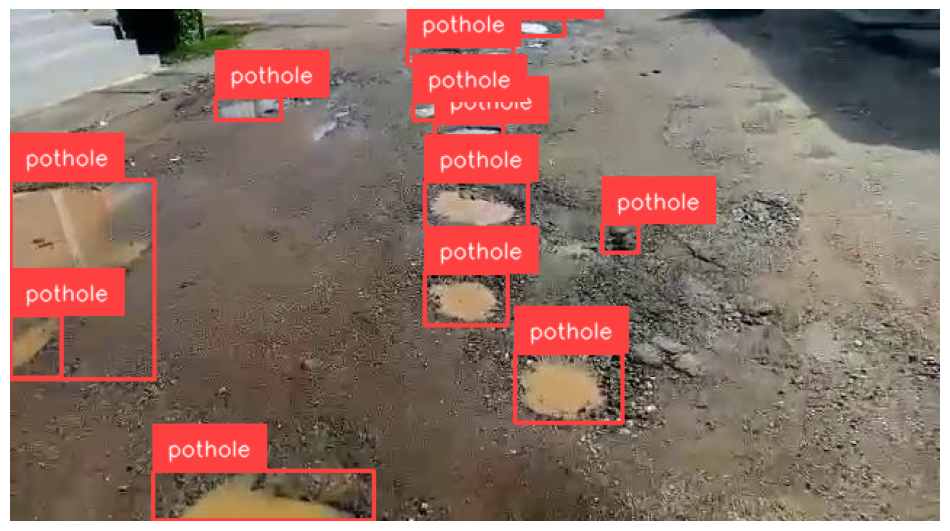

In [23]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)